<h2 style="color:blue" align="center">Graduate Admission Prediction</h2>

#### Import the necessary libraries

In [146]:
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random as python_random
import time, math 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense 
from keras.callbacks import Callback, CSVLogger, EarlyStopping   

import warnings
warnings.filterwarnings('ignore')

#### Reserve GPU memory for the execution

In [147]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

#### Load and split the dataset into training and testing set

In [148]:
df = pd.read_csv('Admission_Predict_Ver1.1.csv')
df=df.drop("Serial No.", axis=1)
print(df.shape)
df.head(5)

(500, 8)


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [149]:
X = np.asarray(df.drop("Chance of Admit ", axis=1))
Y = np.asarray(df["Chance of Admit "])

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#### Normalize the input dataset

In [151]:
mms1 = MinMaxScaler()
mms1.fit(X_train)
X_train_normalized = mms1.transform(X_train)

mms2 = MinMaxScaler()
mms2.fit(X_test)
X_test_normalized = mms2.transform(X_test) 

#### Define DNN model

In [152]:
python_random.seed(7)
np.random.seed(7)
tf.random.set_seed(7)
opti_name = ''

def get_model(): 
    tf.keras.backend.clear_session()
    model = Sequential([ 
        Dense(32, input_dim = 7, activation='relu'),  
        Dense(16, activation='relu'),   
        Dense(1, activation='linear')
    ], name = "DNN_model")
    
    global opti_name
    
    # General SGD
    #opti = keras.optimizers.SGD(learning_rate=0.001)
    #opti_name = 'SGD'
    
    # SGD with momentum
    #opti = keras.optimizers.SGD(learning_rate=0.001, momentum=0.4)
    #opti_name = 'SGD with momentum'
    
    # SGD with Nesterov momentum 
    #opti = keras.optimizers.SGD(learning_rate=0.001, momentum=0.4, nesterov=True)
    #opti_name = 'SGD with Nesterov momentum'
    
    # RMSprop 
    #opti = keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.4)
    #opti_name = 'RMSprop'
    
    # Adam
    opti = keras.optimizers.Adam(learning_rate=0.001) 
    opti_name = 'Adam'
    
    # Adamax
    #opti = keras.optimizers.Adamax(learning_rate=0.001) 
    #opti_name = 'Adamax'
    
    # Nadam
    #opti = keras.optimizers.Nadam(learning_rate=0.001) 
    #opti_name = 'Nadam'  

    
    model.compile(
        optimizer = opti,
        loss = 'mean_squared_error',
        metrics = ['mae']
    )
    
    return model

#### Custom callbacks

For generic optimizer model

In [153]:
# Get the best of base-line model and set it as stopping criteria in HM-based model
generic_best = 0

class CustomCallbackGeneric(Callback):  
    def on_epoch_end(self, epoch, logs={}): 
        global generic_best
        error = round(logs.get('mae'), 4) 
        
        if epoch == 0:
            generic_best = error     
        
        if epoch > 0 and error < generic_best :
            generic_best = error

For HM based optimizer model

In [154]:
class CustomCallbackHM(Callback):  
    initial_weights = 0
    previous_weights = 0
    call_hm = 0  
     
    def on_train_begin(self, logs=None):
        self.initial_weights = model_hm.get_weights() 
        self.initial_weights = np.array(self.initial_weights,dtype=object)
        self.previous_weights = self.initial_weights
        # Harmonic mean based weights calculation
        self.call_hm = np.vectorize(self.apply_hm)  
             
    def on_epoch_end(self, epoch, logs={}):  
        # Set the stopping criteria at (stop_at) the MAE obtained from the baseline model 
        global generic_best 
        
        num_layers = len(model_hm.layers)  
        current_weights = model_hm.get_weights()
        current_weights = np.array(current_weights,dtype=object)        

        for i in range(num_layers):  
            # Harmonic mean based weights calculation
            tensor1 = tf.convert_to_tensor(self.previous_weights[i])
            tensor2 = tf.convert_to_tensor(current_weights[i])
            current_weights[i] = self.call_hm(tensor1, tensor2, epoch)   
            
        # Updating the model with new weights
        model_hm.set_weights(current_weights.tolist())
        self.previous_weights = current_weights
        
        #Stopping criteria
        #if(round(logs.get('mae'), 4) < generic_best):  
            #self.model.stop_training = True
        
    def apply_hm(self, v1, v2, epoch):  
        r = 0
        if epoch < 100:
             r = 1
        elif epoch > 100 and epoch < 200:
             r = 0.85
        elif epoch > 200 and epoch < 300:
             r = 0.75
        else:  
             r = 0.65 

            
        if v1==0 or v2==0:
            return v2
        elif v1 > v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1)*r  
            v2 = v2 - diff
            return v2  
        elif v1 < v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1)*r
            v2 = v2 + diff
            return v2   
        else:
            return v2   

#### Training

Get a model to assign same weights to model with and without HM

In [189]:
model = get_model() 
weights = model.get_weights() 
num_epochs = 100
batch_size = 256

To record loss and accuracy in CSV file

In [190]:
generic_file = '6.GRE '+ opti_name +' optimizer.csv'
hm_file = '6.GRE '+ opti_name +' HM-based optimizer.csv' 
logger_generic_model = CSVLogger(generic_file, append = False, separator=',')
logger_hm_model = CSVLogger(hm_file, append = False, separator=',')

Generic opimizer model

In [191]:
model_wihtout_hm = get_model()
model_wihtout_hm.set_weights(weights) 
st = time.time() 
model_wihtout_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=0, callbacks=[CustomCallbackGeneric(), logger_generic_model], batch_size=batch_size) 
et = time.time()
elapsed_training_time_generic = round(et - st, 4)
print('Execution time:', elapsed_training_time_generic, 'seconds') 

Execution time: 0.4411 seconds


HM based optimizer model

In [192]:
model_hm = get_model()
model_hm.set_weights(weights) 
st = time.time()
model_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=0, callbacks=[CustomCallbackHM(),logger_hm_model], batch_size=batch_size) 
et = time.time()
elapsed_training_time_hm = round(et - st, 4)
print('Execution time:', elapsed_training_time_hm, 'seconds') 

Execution time: 0.6013 seconds


Model summary

In [193]:
model_hm.summary()

Model: "sequential_232"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_696 (Dense)           (None, 32)                256       
                                                                 
 dense_697 (Dense)           (None, 16)                528       
                                                                 
 dense_698 (Dense)           (None, 1)                 17        
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


#### Generic optimizer vs HM-based optimizer

In [194]:
df1 = pd.read_csv(generic_file)
df2 = pd.read_csv(hm_file)

Loss

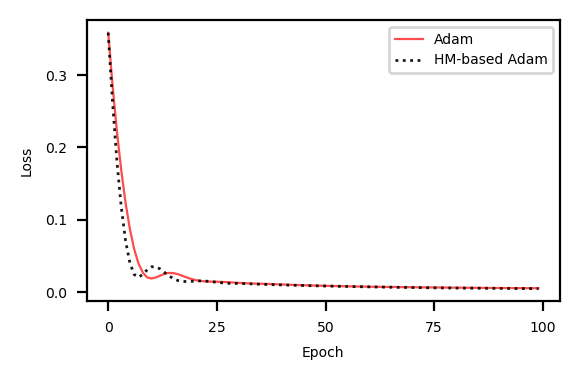

In [195]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['loss'] 
y2 = df2['loss']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Loss' , fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5}) 
#plt.yscale('log')
#plt.title("Loss", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()

MAE

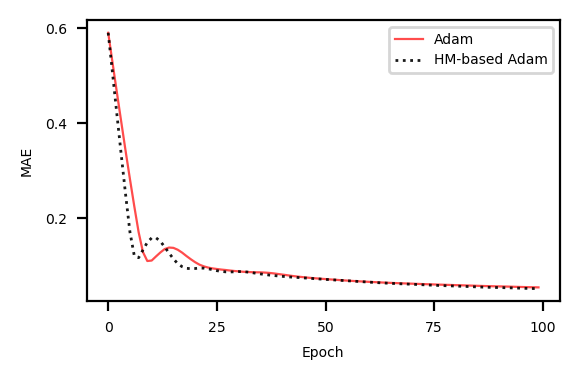

In [196]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['mae'] 
y2 = df2['mae']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('MAE' , fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5}) 
#plt.yscale('log')
#plt.title("MAE", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()

#### Testing the model

Generic opimizer model

In [197]:
generic_testing = model_wihtout_hm.evaluate(X_test_normalized, y_test)
generic_testing  

4/4 [==============================] - 0s 1ms/step - loss: 0.0097 - mae: 0.0793


[0.009713925421237946, 0.0793430432677269]

HM based optimizer model

In [198]:
hm_testing = model_hm.evaluate(X_test_normalized, y_test)
hm_testing

4/4 [==============================] - 0s 1ms/step - loss: 0.0082 - mae: 0.0738


[0.008230985142290592, 0.07376941293478012]

<h2 style="color:blue" align="center">Training Loss vs Validation Loss</h2>

For generic optimizer

In [199]:
model_wihtout_hm_val = get_model()
model_wihtout_hm_val.set_weights(weights) 
history = model_wihtout_hm_val.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=0, validation_split=0.2, batch_size=batch_size) 

In [200]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

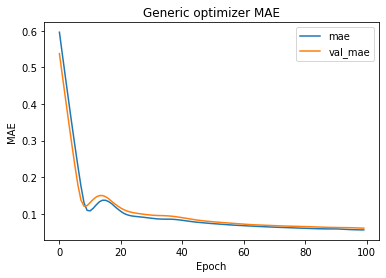

In [201]:
plt.figure(figsize=(6,4))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Generic optimizer MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['mae', 'val_mae'], loc='upper right')
plt.show()

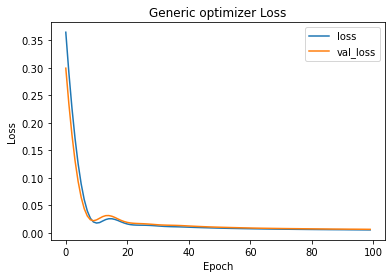

In [202]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Generic optimizer Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

For HM-based optimizer

In [203]:
model_wiht_hm_val = get_model()
model_wiht_hm_val.set_weights(weights) 
history_hm = model_wiht_hm_val.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=0, validation_split=0.2, callbacks=[CustomCallbackHM()], batch_size=batch_size) 

In [204]:
history_hm.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

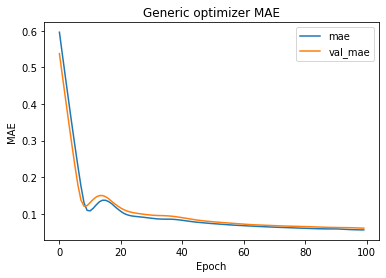

In [205]:
plt.figure(figsize=(6,4))
plt.plot(history_hm.history['mae'])
plt.plot(history_hm.history['val_mae'])
plt.title('Generic optimizer MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['mae', 'val_mae'], loc='upper right')
plt.show()

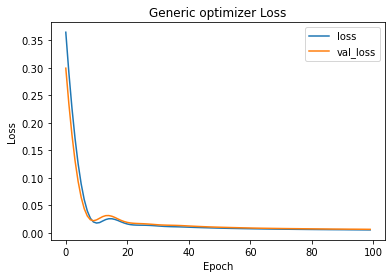

In [206]:
plt.figure(figsize=(6,4))
plt.plot(history_hm.history['loss'])
plt.plot(history_hm.history['val_loss'])
plt.title('Generic optimizer Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

<h2 style="color:blue" align="center">Cross Validation</h2>

In [177]:
num_folds = 5 
# Merge inputs and targets
inputs = np.concatenate((X_train_normalized, X_test_normalized), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits = num_folds, shuffle = False)

# Define per-fold score containers  
mae_per_fold = []
loss_per_fold = []

mae_per_fold_hm = []
loss_per_fold_hm = [] 
 
# K-fold Cross Validation model evaluation
fold_no = 1

model = get_model() 
weights = model.get_weights() 

for train, test in kfold.split(inputs, targets):    
    model_wihtout_hm = get_model()
    model_wihtout_hm.set_weights(weights) 
    model_wihtout_hm.fit(inputs[train], targets[train], epochs = num_epochs, verbose = 0, batch_size = batch_size) 
    scores = model_wihtout_hm.evaluate(inputs[test], targets[test], verbose = 0)
    #print(f'Score for fold {fold_no}: {model_wihtout_hm.metrics_names[0]} of {scores[0]}; {model_wihtout_hm.metrics_names[1]} of {scores[1]}') 
    mae_per_fold.append(scores[1]) 
    loss_per_fold.append(scores[0])
    
    model_hm = get_model() 
    model_hm.set_weights(weights) 
    model_hm.fit(inputs[train], targets[train], epochs = num_epochs, verbose = 0, callbacks=[CustomCallbackHM()], batch_size = batch_size) 
    scores_hm = model_hm.evaluate(inputs[test], targets[test], verbose = 0)
    #print(f'Score for fold {fold_no}: {model_hm.metrics_names[0]} of {scores_hm[0]}; {model_hm.metrics_names[1]} of {scores_hm[1]}') 
    mae_per_fold_hm.append(scores_hm[1]) 
    loss_per_fold_hm.append(scores_hm[0])
    
    fold_no = fold_no + 1 

In [178]:
# == Provide average scores ==
print('-------------------------------------------')
print('Score per fold for model without HM')
for i in range(0, num_folds):
  print('-------------------------------------------')
  print(f'> Fold {i+1} - Loss: {round(loss_per_fold[i],5)} - MAE: {round(mae_per_fold[i],5)}')
print('-------------------------------------------')
print('Average scores for all folds:')
print(f'> MAE: {round(np.mean(mae_per_fold),5)} (+- {round(np.std(mae_per_fold),5)})')
print(f'> Loss: {round(np.mean(loss_per_fold),5)}')
print('-------------------------------------------')
print('Score per fold for model with HM')
for i in range(0, num_folds):
  print('-------------------------------------------')
  print(f'> Fold {i+1} - Loss: {round(loss_per_fold_hm[i],5)} - MAE: {round(mae_per_fold_hm[i],5)}')
print('-------------------------------------------')
print('Average scores for all folds:')
print(f'> MAE: {round(np.mean(mae_per_fold_hm),5)} (+- {round(np.std(mae_per_fold_hm),5)})')
print(f'> Loss: {round(np.mean(loss_per_fold_hm),5)}')
print('-------------------------------------------')

-------------------------------------------
Score per fold for model without HM
-------------------------------------------
> Fold 1 - Loss: 0.00468 - MAE: 0.04569
-------------------------------------------
> Fold 2 - Loss: 0.00357 - MAE: 0.0433
-------------------------------------------
> Fold 3 - Loss: 0.00378 - MAE: 0.04405
-------------------------------------------
> Fold 4 - Loss: 0.00449 - MAE: 0.04406
-------------------------------------------
> Fold 5 - Loss: 0.00749 - MAE: 0.0671
-------------------------------------------
Average scores for all folds:
> MAE: 0.04884 (+- 0.00916)
> Loss: 0.0048
-------------------------------------------
Score per fold for model with HM
-------------------------------------------
> Fold 1 - Loss: 0.00474 - MAE: 0.04601
-------------------------------------------
> Fold 2 - Loss: 0.00358 - MAE: 0.04274
-------------------------------------------
> Fold 3 - Loss: 0.00374 - MAE: 0.04447
-------------------------------------------
> Fold 4 - L

#### Release the GPU memory